### 1.1 PCA scores/cNMF weights with EDS element

In [1]:
import pandas as pd
import numpy as np
from orix import io
import kikuchipy as kp
import ast
from data_preprocessing import get_eds_average, fit_preprocessors, apply_preprocessors, coord_xmap_dict
from sklearn.model_selection import train_test_split
from contrastivemodel import train_and_evaluate, evaluate_contrastive
from visualize_contrastive import visualize_loss_curve, visualize_contrastive_embeddings, visualize_contrastive_embeddings_by_element, visualize_contrastive_embeddings_by_phase

In [2]:
pca_scores= pd.read_csv('../micro_segmentation/pca_scores1.csv',  header=None, skiprows=1)  # shape (961,10)
pca_scores.iloc[:, 0] = pca_scores.iloc[:, 0].apply(
    lambda s: ast.literal_eval(s) if isinstance(s, str) else s
)

cnmf_w    = pd.read_csv('../micro_segmentation/weight1.csv', header=None, skiprows=1) # shape (961,2)
loc =pca_scores.iloc[:,0]

pca_scores = pca_scores.iloc[:,1:]
cnmf_w = cnmf_w.iloc[:,1:]
pca_scores.columns= [f'PC_{i+1}'   for i in pca_scores.columns]
cnmf_w.columns    = ['cNMF_1', 'cNMF_2']
roi_xrange=(20, 51)
roi_yrange=(5, 36)
edax_binary_path = "../micro_segmentation/EBSD_scan/Scan3_cropped.up1"
fname_ang = "../micro_segmentation/EBSD_scan/Scan3_cropped.ang"
xmap = io.load(fname_ang)

xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")
s_edax = kp.load(edax_binary_path)
s_edax.xmap = xmap
coor_dict = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)
roi_eds = get_eds_average(roi_xrange, roi_yrange, s_edax, 'roi')


/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/orix/io/plugins/ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(
/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/numba/cuda/cudadrv/nvvm.py:368: UserWarning: CUDA Toolkit 11.1 is unsupported by Numba - 11.2 is the minimum required version.
  warnings.warn(unsupported_ver)


In [13]:
print(roi_eds)

            O        Mg        Al        Si        Ti        Mn        Fe
0    0.598795  0.030120  0.018072  0.032530  0.008434  0.010843  0.301205
1    0.600372  0.032838  0.030979  0.026022  0.014250  0.006815  0.288724
2    0.598494  0.031995  0.018821  0.028231  0.009410  0.008156  0.304893
3    0.588938  0.037084  0.033941  0.028913  0.009428  0.008171  0.293526
4    0.613435  0.034854  0.024081  0.025349  0.013308  0.011407  0.277567
..        ...       ...       ...       ...       ...       ...       ...
956  0.604116  0.039346  0.019976  0.028450  0.010896  0.005448  0.291768
957  0.647169  0.030492  0.023647  0.019913  0.011823  0.008712  0.258245
958  0.624553  0.032181  0.025626  0.023242  0.016687  0.010131  0.267580
959  0.619869  0.032719  0.026770  0.027365  0.009518  0.009518  0.274242
960  0.602596  0.038319  0.023486  0.027194  0.015451  0.014833  0.278121

[961 rows x 7 columns]


In [12]:
s_edax.inav[20:21, 7:8].xmap.prop['Mg']

array([51.])

In [4]:
min(roi_eds[:,-1])

np.float64(385.0)

In [5]:
def normalize_roi_data_vectorized(roi_data):
    row_sums = np.nansum(roi_data, axis=1)

    row_sums[row_sums == 0] = 1
    
    normalized_data = roi_data / row_sums[:, np.newaxis]
    
    all_nan_rows = np.all(np.isnan(roi_data), axis=1)
    normalized_data[all_nan_rows] = 0
    
    return normalized_data
roi_eds = normalize_roi_data_vectorized(roi_eds)
roi_eds = pd.DataFrame(roi_eds, columns=['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe'])
all_data = pd.concat([pca_scores, cnmf_w, roi_eds], axis=1)

In [6]:
train_df, test_df = train_test_split(all_data, test_size=0.2, random_state=42, shuffle=True)

loc_train = loc.loc[train_df.index]
loc_test  = loc.loc[test_df.index]

transformers = fit_preprocessors(
    train_df,
    pca_scale='standard',     
    cnmf_transform='clr',     
    elem_transform='raw' 
)

train_data = apply_preprocessors(train_df, transformers)
test_data  = apply_preprocessors(test_df, transformers)

In [7]:
feature_pc_cols = [c for c in test_data.columns if 'PC_' in c]
feature_cnmf_cols = [c for c in test_data.columns if 'cNMF_' in c]
element_cols = ['O', 'Mg', 'Al', 'Si', 'Ti', 'Mn', 'Fe']


features_pc_np = test_data[feature_pc_cols].values.astype(np.float32)
features_cnmf_np = test_data[feature_cnmf_cols].values.astype(np.float32)
elements_np = test_data[element_cols].values.astype(np.float32)

In [52]:
# Train the model
print("Training PCA Model...")
pca_model, pca_train_losses, pca_test_losses, final_alignment_pca, final_uniformity_pca = train_and_evaluate(
    'pca', train_data, test_data, output_dim=3, latent_dim=128, num_epochs=100, batch_size=64, lr=1e-3,temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)

# print("\nTraining cNMF Model...")
#cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
#    'cnmf', train_data, test_data, output_dim=32, latent_dim=128,num_epochs=200, batch_size=32, lr=1e-3, temperature=0.2
#)

Training PCA Model...
Epoch 1: Alignment=0.0807, Uniformity=-0.1396 | ||zf||=1.000 ||ze||=1.000
Epoch [1/100], PCA - Train Loss: 4.1703, Test Loss: 3.1191, Temp: 1.0000
Epoch [2/100], PCA - Train Loss: 4.1575, Test Loss: 3.1190, Temp: 1.0070
Epoch [3/100], PCA - Train Loss: 4.1586, Test Loss: 3.1187, Temp: 1.0089
Epoch [4/100], PCA - Train Loss: 4.1580, Test Loss: 3.1182, Temp: 1.0096
Epoch [5/100], PCA - Train Loss: 4.1553, Test Loss: 3.1160, Temp: 1.0097
Epoch [6/100], PCA - Train Loss: 4.1470, Test Loss: 3.0938, Temp: 1.0088
Epoch [7/100], PCA - Train Loss: 4.1132, Test Loss: 3.0469, Temp: 1.0059
Epoch [8/100], PCA - Train Loss: 4.0714, Test Loss: 3.0513, Temp: 1.0038
Epoch [9/100], PCA - Train Loss: 3.9778, Test Loss: 2.9553, Temp: 1.0006
Epoch [10/100], PCA - Train Loss: 3.9605, Test Loss: 2.9517, Temp: 0.9892
Epoch 11: Alignment=0.6788, Uniformity=-1.1307 | ||zf||=1.000 ||ze||=1.000
Epoch [11/100], PCA - Train Loss: 3.9017, Test Loss: 2.9378, Temp: 0.9753
Epoch [12/100], PCA - Tr

In [42]:
print("\nTraining cNMF Model...")
cnmf_model, cnmf_train_losses, cnmf_test_losses, final_alignment_cnmf, final_uniformity_cnmf = train_and_evaluate(
    'cnmf', train_data, test_data, output_dim=2, latent_dim=64,num_epochs=100, batch_size=64, lr=1e-3, temperature=1,learnable_temp=True, min_temp=0.01, max_temp=2, temp_anneal=False
)


Training cNMF Model...
Epoch 1: Alignment=0.0508, Uniformity=-0.0979 | ||zf||=1.000 ||ze||=1.000
Epoch [1/100], CNMF - Train Loss: 4.1592, Test Loss: 3.1168, Temp: 1.0000
Epoch [2/100], CNMF - Train Loss: 4.1539, Test Loss: 3.1103, Temp: 1.0063
Epoch [3/100], CNMF - Train Loss: 4.1268, Test Loss: 3.1082, Temp: 1.0070
Epoch [4/100], CNMF - Train Loss: 4.1025, Test Loss: 3.0403, Temp: 1.0008
Epoch [5/100], CNMF - Train Loss: 4.0406, Test Loss: 3.0150, Temp: 0.9987
Epoch [6/100], CNMF - Train Loss: 4.0382, Test Loss: 2.9957, Temp: 0.9918
Epoch [7/100], CNMF - Train Loss: 4.0118, Test Loss: 3.0044, Temp: 0.9857
Epoch [8/100], CNMF - Train Loss: 4.0040, Test Loss: 2.9890, Temp: 0.9796
Epoch [9/100], CNMF - Train Loss: 3.9837, Test Loss: 2.9846, Temp: 0.9708
Epoch [10/100], CNMF - Train Loss: 3.9863, Test Loss: 2.9895, Temp: 0.9629
Epoch 11: Alignment=0.6782, Uniformity=-0.9091 | ||zf||=1.000 ||ze||=1.000
Epoch [11/100], CNMF - Train Loss: 3.9788, Test Loss: 3.0085, Temp: 0.9577
Epoch [12/1

[eval] features zf: shape=(193, 3), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.416673, pairwise-dist(mean)=0.887695
[eval] features zf: approx unique rows (4dp) = 193
[eval] elements ze: shape=(193, 3), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.401463, pairwise-dist(mean)=0.849405
[eval] elements ze: approx unique rows (4dp) = 193
[Retrieval] Top-1/5/10: {1: 0.02072538860103627, 5: 0.046632124352331605, 10: 0.09844559585492228} | Median rank: 52.0
[Logit gap] mean/median: -0.19731159508228302 -0.07296186685562134
[Pair cosine distance] mean/std/min/max: 0.22081230580806732 0.28044798970222473 0.00718158483505249 1.5816344022750854
[W&I] Alignment=0.4416  Uniformity=-0.9786


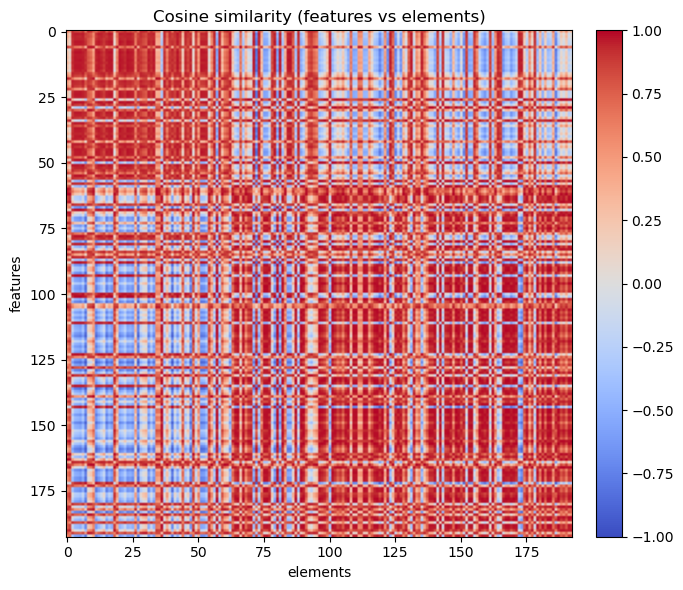

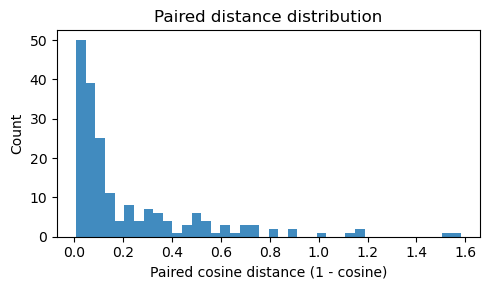

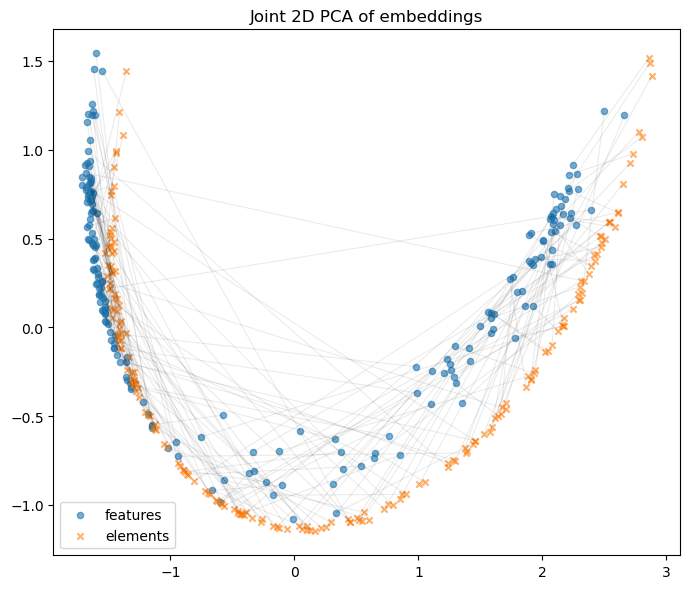

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


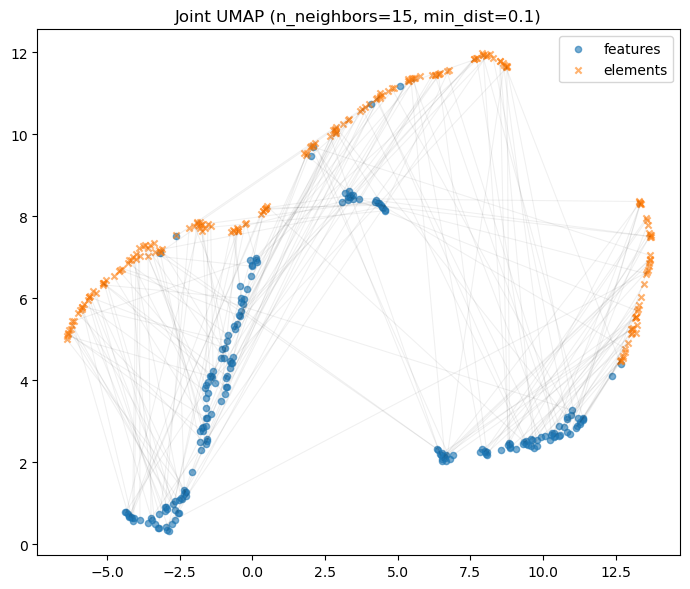

In [53]:
phase_map = {2: 'FeO', 3: 'Fe'}
e_metrics = evaluate_contrastive(pca_model,features_pc_np,elements_np,loc_test,coor_dict,phase_map,True)

[eval] features zf: shape=(193, 2), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.388179, pairwise-dist(mean)=0.617347
[eval] features zf: approx unique rows (4dp) = 191
[eval] elements ze: shape=(193, 2), row-norm(mean±std)=1.0000±0.0000, per-dim std(mean)=0.363956, pairwise-dist(mean)=0.639010
[eval] elements ze: approx unique rows (4dp) = 193
[Retrieval] Top-1/5/10: {1: 0.0, 5: 0.02072538860103627, 10: 0.06217616580310881} | Median rank: 59.0
[Logit gap] mean/median: -0.1244133859872818 -0.052491188049316406
[Pair cosine distance] mean/std/min/max: 0.12455061823129654 0.1702229380607605 6.41942024230957e-05 0.958085834980011
[W&I] Alignment=0.2491  Uniformity=-0.6665


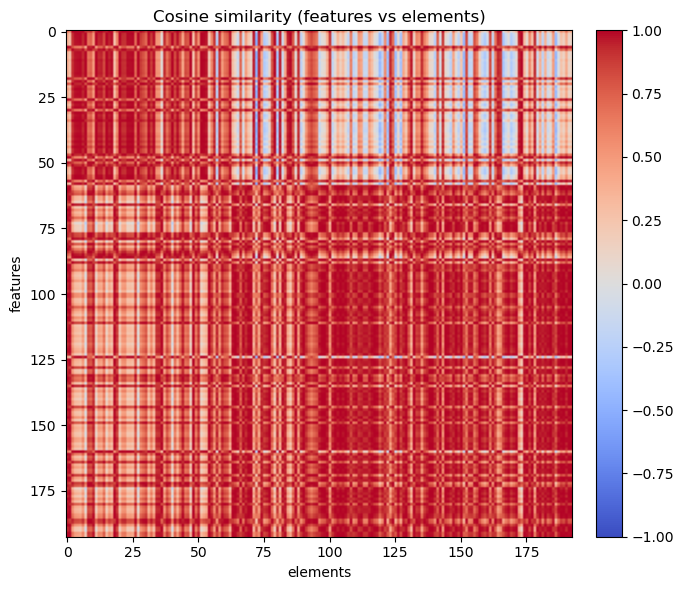

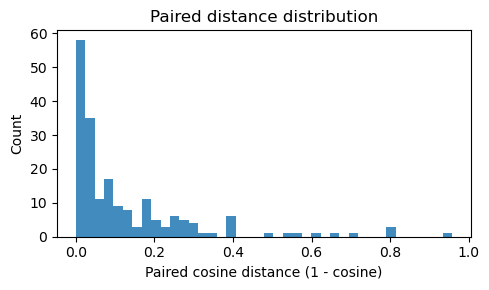

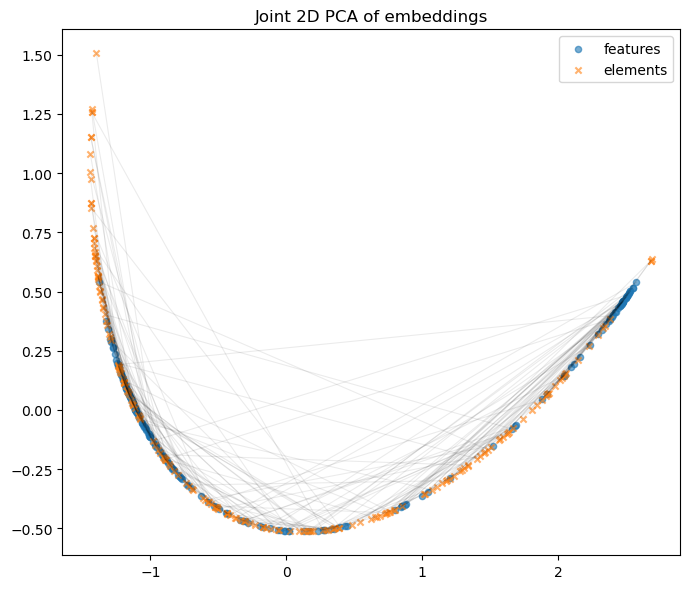

/home/users/zhangqn8/anaconda3/envs/kp/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


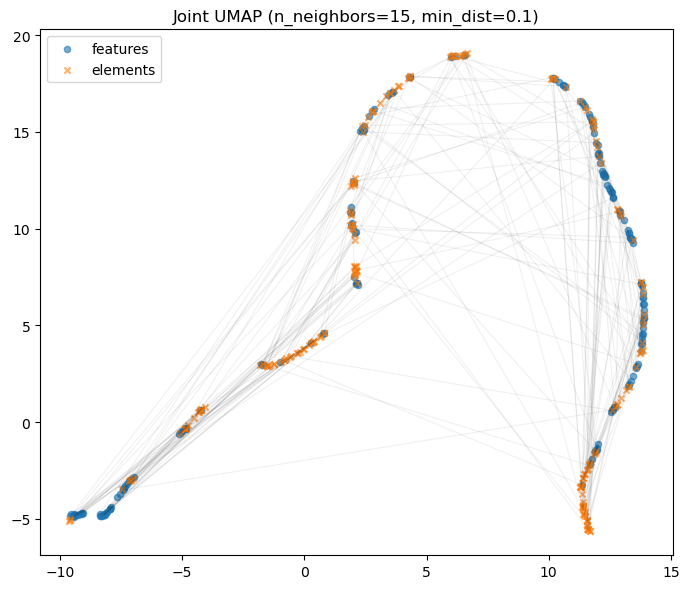

In [43]:
e_metrics_c=evaluate_contrastive(cnmf_model,features_cnmf_np,elements_np,loc_test,coor_dict,phase_map,True)

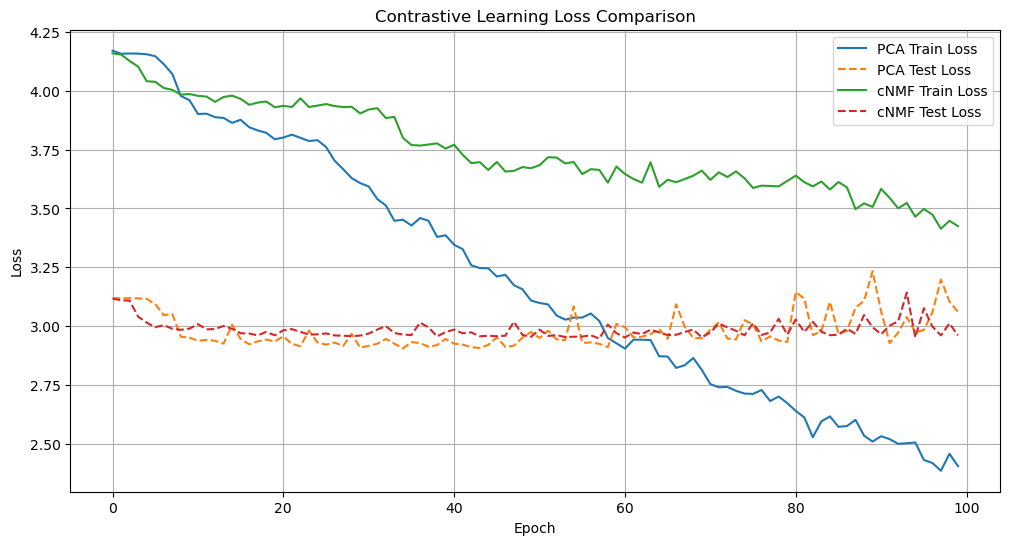

In [54]:
visualize_loss_curve(pca_model, cnmf_model, test_data, pca_train_losses, pca_test_losses, cnmf_train_losses, cnmf_test_losses)

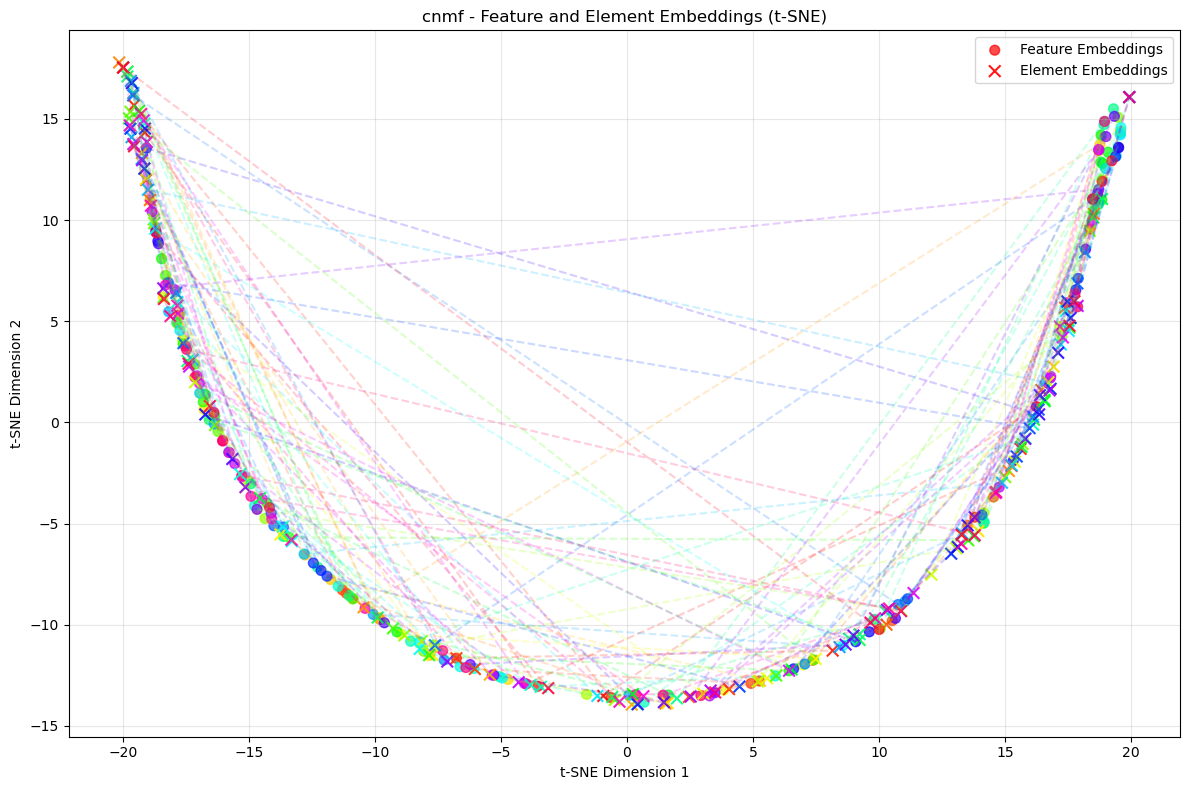

Average distance between feature and element embeddings: 16.2565


In [50]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(cnmf_model, test_data, 'cnmf')


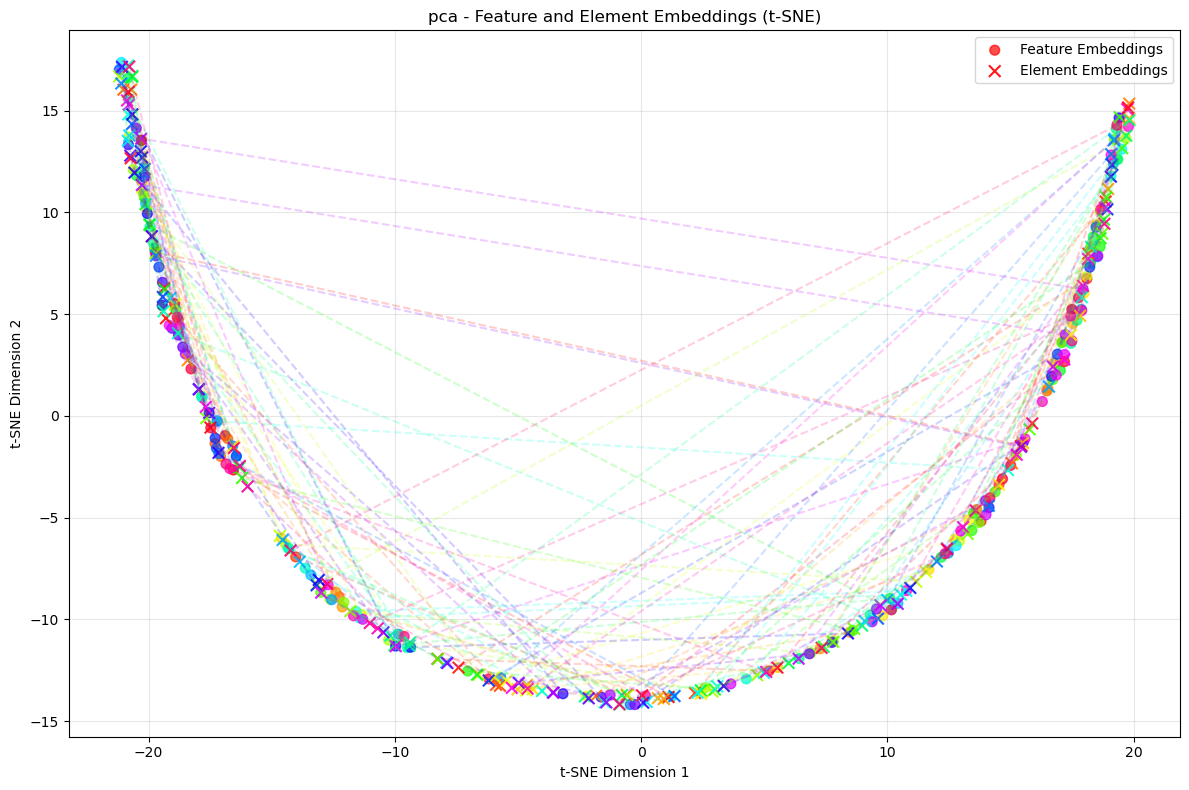

Average distance between feature and element embeddings: 14.6807


In [51]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings(pca_model, test_data, 'pca')

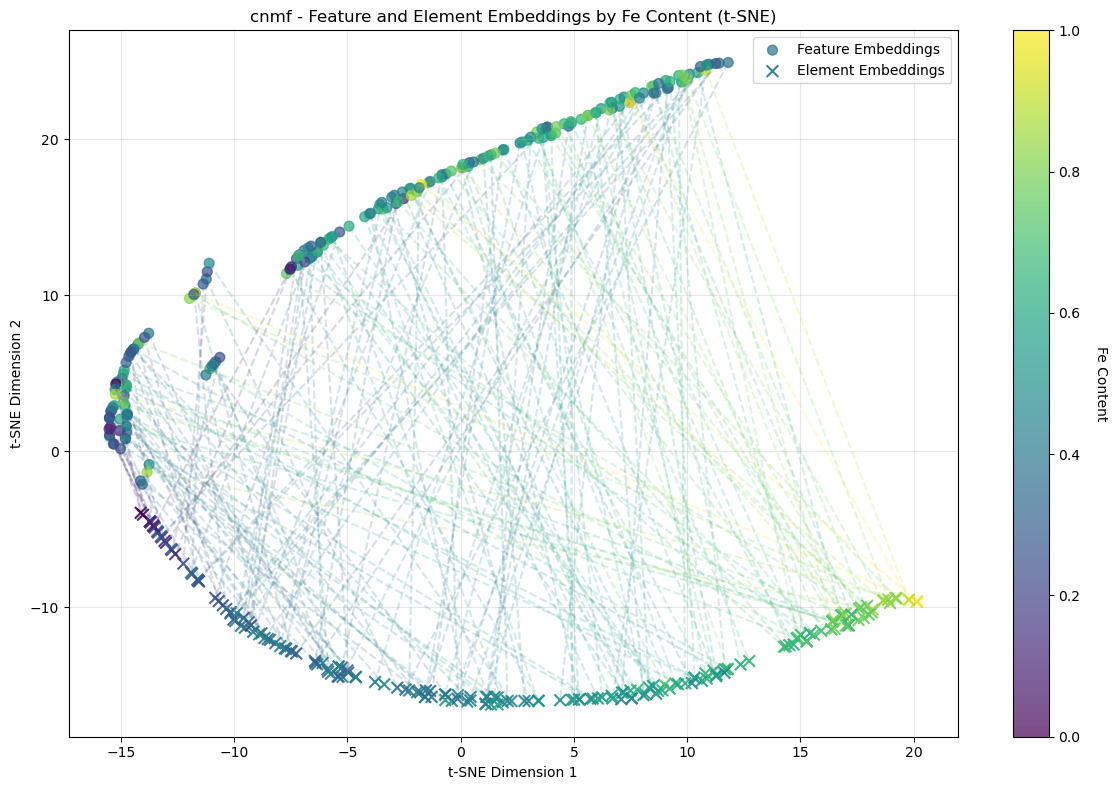

Average distance between feature and element embeddings: 29.5228
Correlation between distance and Fe content: 0.6060


In [12]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'Fe')

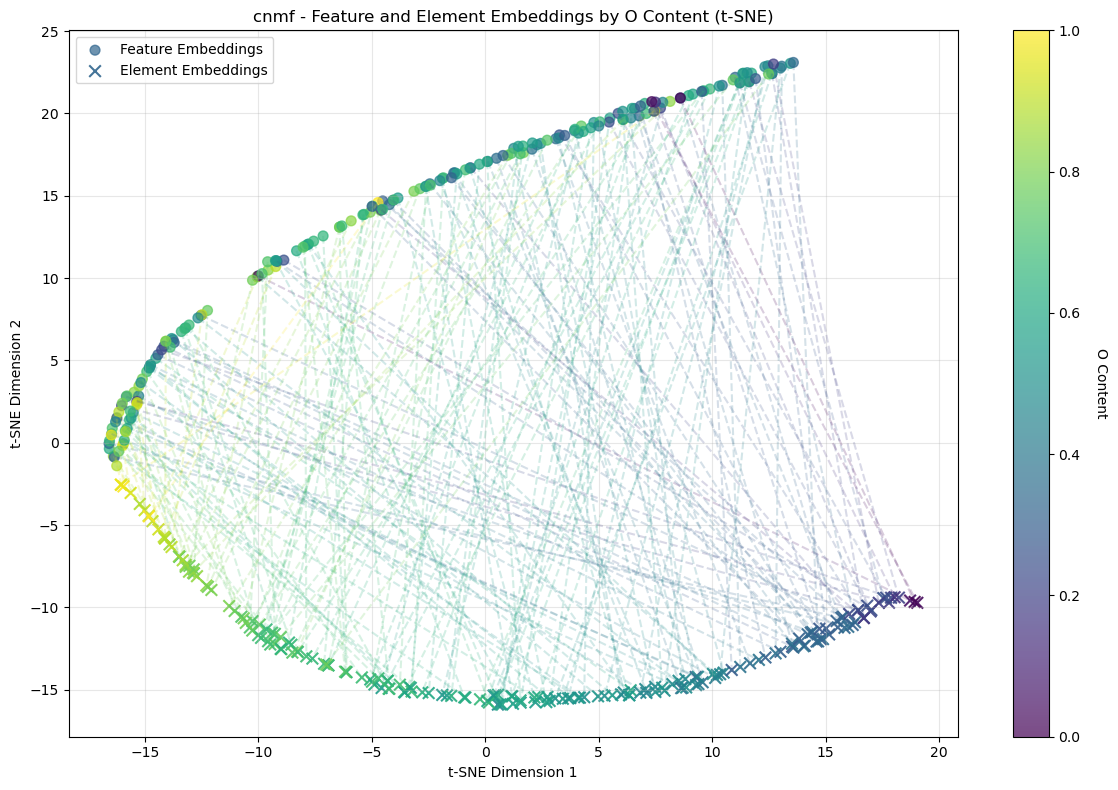

Average distance between feature and element embeddings: 28.8098
Correlation between distance and O content: -0.6064


In [14]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(cnmf_model, test_data, 'cnmf', 'O')

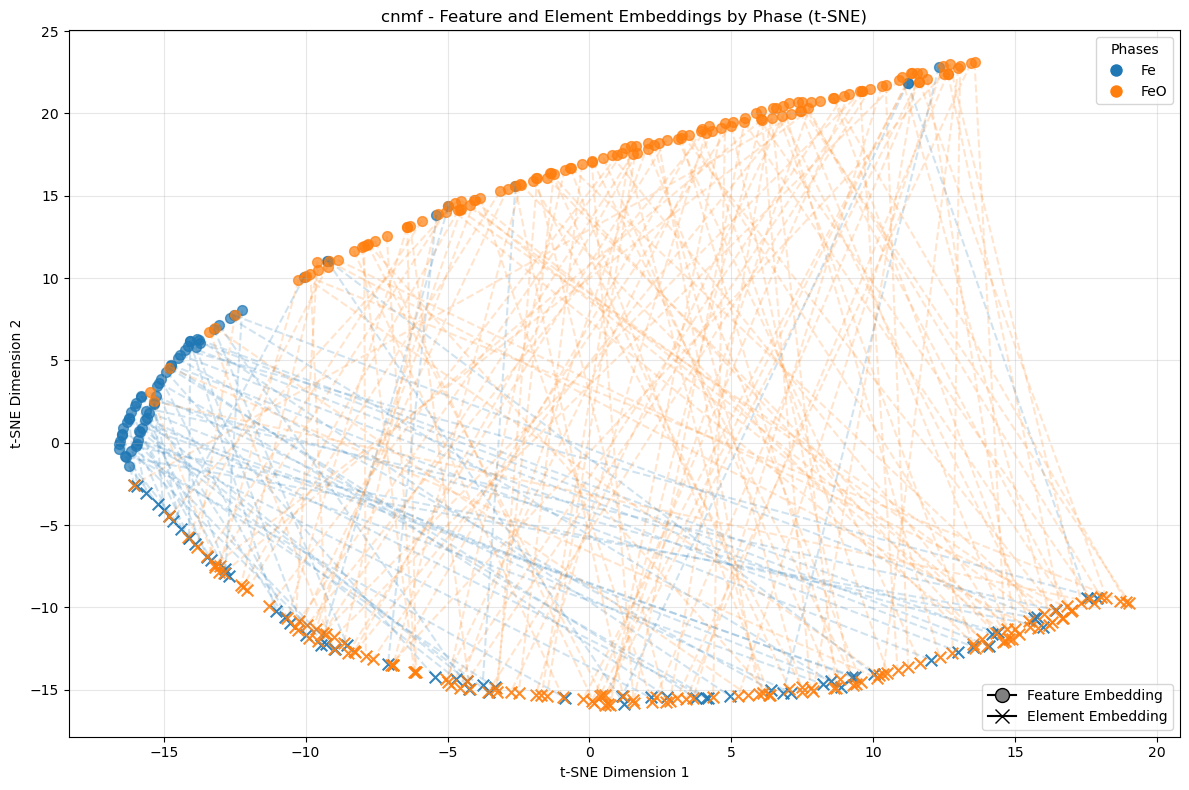

Average distance between feature and element embeddings: 28.8098

Distance by phase:
Fe: 22.2066
FeO: 31.9350


In [15]:
phase_map = {2: 'FeO', 3: 'Fe'}
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(cnmf_model, test_data, loc_testdata, coor_dict, phase_map, 'cnmf')

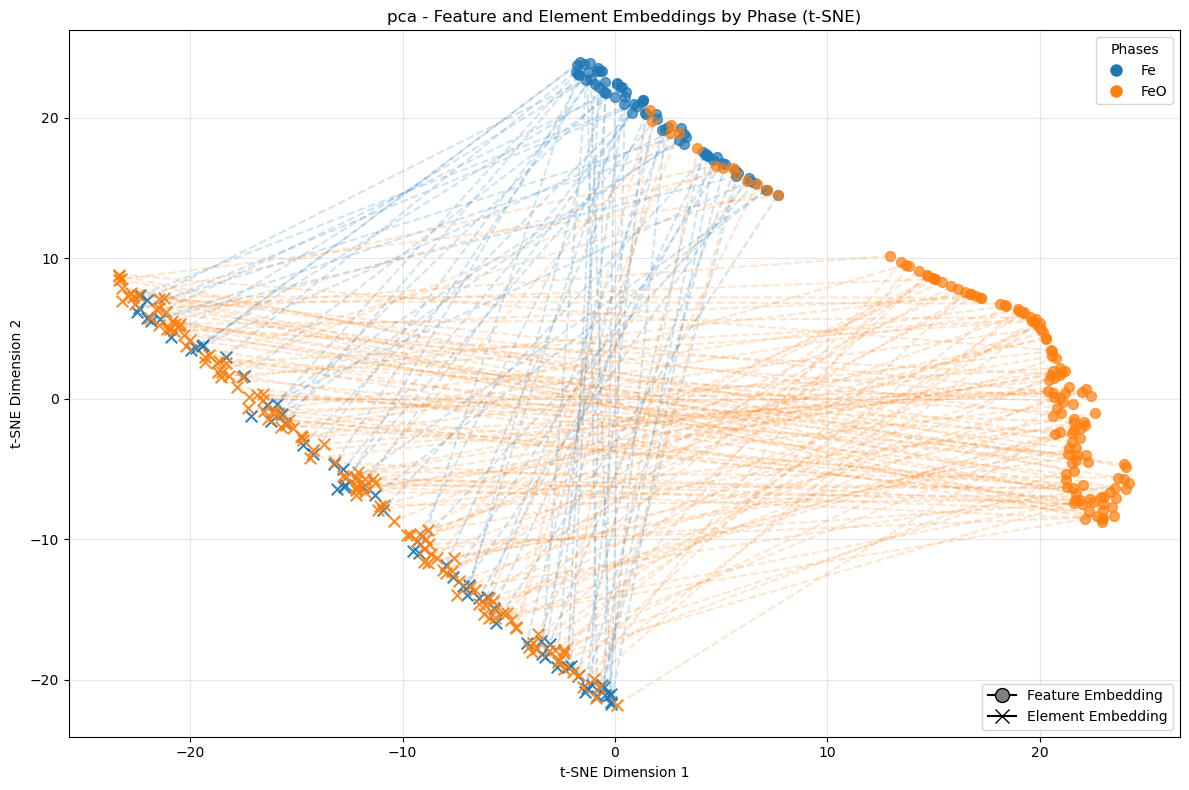

Average distance between feature and element embeddings: 34.9218

Distance by phase:
Fe: 33.1976
FeO: 35.7378


In [13]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_phase(pca_model, test_data, loc_testdata, coor_dict, phase_map, 'pca')

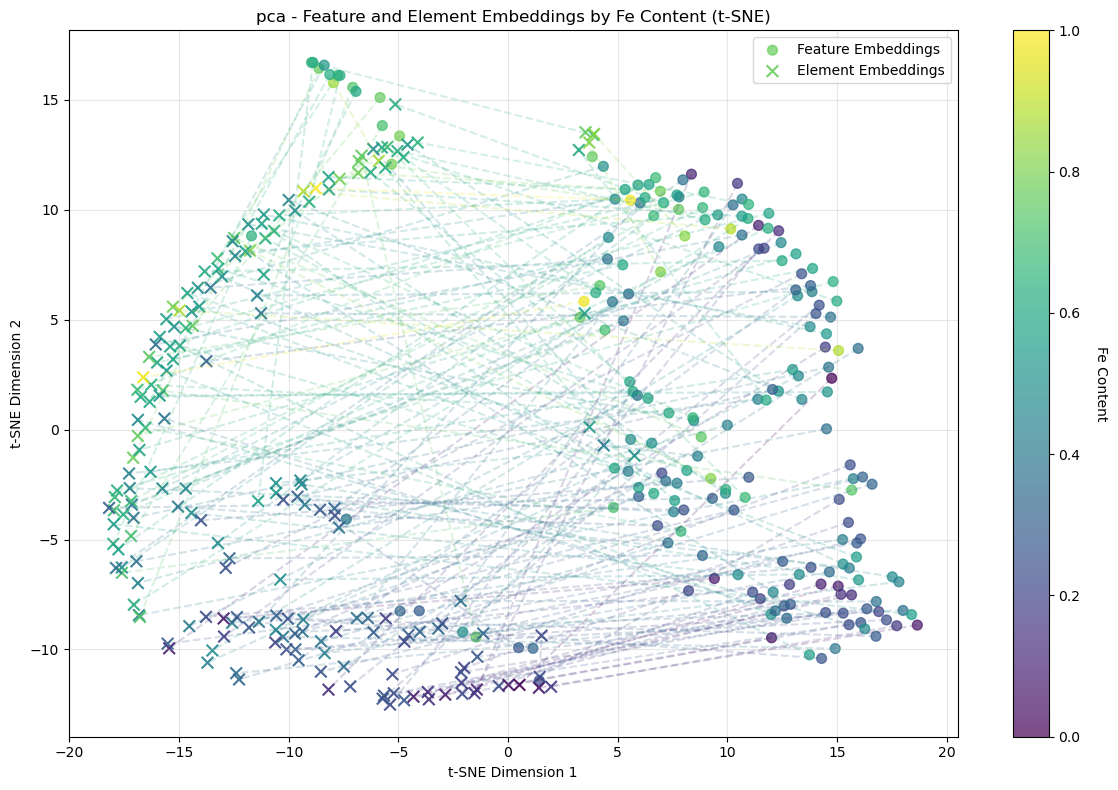

Average distance between feature and element embeddings: 21.4849
Correlation between distance and Fe content: -0.1069


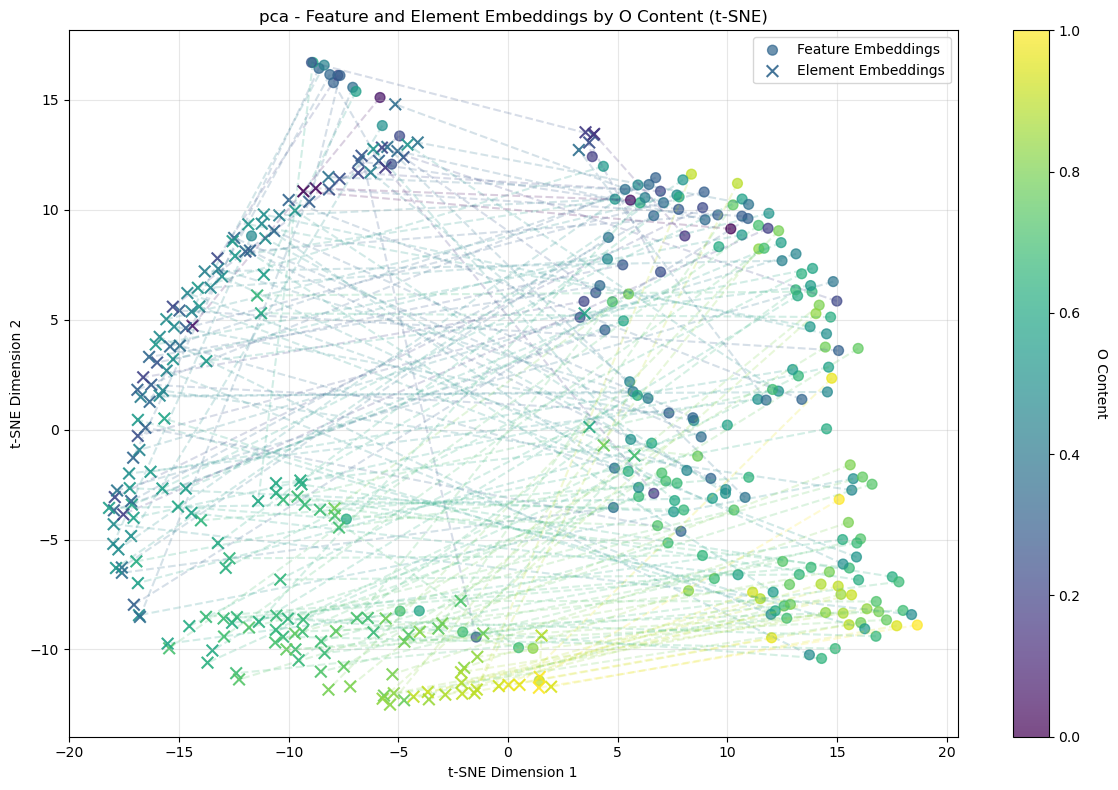

Average distance between feature and element embeddings: 21.4849
Correlation between distance and O content: 0.0334


In [13]:
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'Fe')
feature_tsne, element_tsne, distances = visualize_contrastive_embeddings_by_element(pca_model, test_data, 'pca', 'O')